In [2]:
import warnings, sys, os, glob, random, math
warnings.filterwarnings('ignore')
import re
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.path as mplPath
import matplotlib.colors as colors
from scipy.signal import convolve2d
import pickle
import sunpy
from sunpy.coordinates import Helioprojective
from astropy.visualization import ImageNormalize, SqrtStretch
#plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
#import sunpy.coordinates.sun as sun_coord
from fwdtools import *

### Inputs 

In [3]:
basedir = '/HDD/mnedal'
psimas_date = '2019-04-01'
psimasres = '4R'
YEAR = '2019'
MONTH = '04'
#DAY = '03'
#HOUR = '12'
FOV = 3750

In [4]:
def get_colors(n):
    '''
    Generate a list of (n) hex colors.
    '''
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    hex_colors = [mcolors.to_hex(c) for c in colors]
    hex_colors[0] = '#0000ff' # set first color to blue
    hex_colors[-1] = '#ff0000' # set last color to red
    return hex_colors



def generate_random_points_within_ellipse(contour_colors, num_rand_points, xell, yell, increment_dist, centroid_X, centroid_Y, points):
    """
    Generates random points within the limits of an ellipse shape defined by a contour path.

    Parameters:
        contour_colors (list): List of colors corresponding to the contour points.
        num_rand_points (int): Number of random points to generate within the ellipse.
        xell (numpy array): X-coordinates of the ellipse defining its shape.
        yell (numpy array): Y-coordinates of the ellipse defining its shape.
        increment_dist (int): The minimum distance between random points and the centroid.
        centroid_X (float): X-coordinate of the centroid point.
        centroid_Y (float): Y-coordinate of the centroid point.
        points (list): List of points defining the path of the ellipse.

    Returns:
        xnew (list): List of X-coordinates of the newly generated random points.
        ynew (list): List of Y-coordinates of the newly generated random points.

    The function generates random points within the ellipse shape defined by the contour path
    represented by 'xell' and 'yell' coordinates. The number of random points generated is determined
    by 'num_rand_points'. The generated points will be at least 'increment_dist' units away from the
    specified centroid point ('centroid_X' and 'centroid_Y') to ensure they are not too close to it.

    The function checks whether each randomly generated point is inside the ellipse by constructing
    a path using the 'points' list and checks for containment using a matplotlib Path object.

    The function also plots the generated points on a scatter plot using the 'contour_colors' list
    to assign colors to each contour. Note that the plotting functionality is commented out in the
    function, and you can uncomment it if you wish to visualize the generated points.
    """
    # create empty lists to store the new point coordinates
    xnew, ynew = [], []
    
    # set the centroid number as zero in the beginning
    cnum = 0
    
    for i in range(len(contour_colors)):
        # generate a fixed length of random centroids
        if len(xnew) < num_rand_points:
            # I chose to take the int of the max limit to ensure that the generated number is below that value, round to the nearest int by `ceil`
            xgen = random.randrange(start=round(np.ceil(xell).min()), stop=int(np.ceil(xell).max()), step=increment_dist)
            ygen = random.randrange(start=round(np.ceil(yell).min()), stop=int(np.ceil(yell).max()), step=increment_dist)

            # make sure the generated point is not close to the original centroid point
            if abs(xgen - centroid_X) > increment_dist or abs(ygen - centroid_Y) > increment_dist:
                # define the coord of the new point 
                point = (xgen, ygen)

                # make a path from the centroid's points
                poly_path = mplPath.Path(points)

                # check if the generated point is inside the ellipse and plot it
                if poly_path.contains_point(point):
                    plt.scatter(point[0], point[1], color=contour_colors[i], alpha=0.7, s=7, label=f'$C_{cnum}$')
                    # store the new point coords in a dict 
                    xnew.append(point[0])
                    ynew.append(point[1])
                    cnum += 1
        else:
            break
    
    return xnew, ynew

In [5]:
# fetch the filenames and their paths 
lofar_dirtyfile = glob.glob('/HDD/mnedal/output_snapshots/max_baseline/*-dirty.fits')
lofar_imagefile = glob.glob('/HDD/mnedal/output_snapshots/max_baseline/*-image.fits')
lofar_resfile = glob.glob('/HDD/mnedal/output_snapshots/max_baseline/*-residual.fits')
lofar_psffile = glob.glob('/HDD/mnedal/output_snapshots/max_baseline/*-psf.fits')

# sort the lists 
lofar_dirtyfile.sort()
lofar_imagefile.sort()
lofar_resfile.sort()
lofar_psffile.sort()

In [6]:
# extract the burst numbers using regular expressions 
burst_numbers = [int(re.search(r'burst_(\d+)', filename).group(1)) for filename in lofar_imagefile]

# find the unique burst numbers using a set 
unique_burst_numbers = set(burst_numbers)

# convert a set to a list 
unique_burst_numbers = list(unique_burst_numbers)

# print the unique burst numbers 
print(unique_burst_numbers)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [7]:
# make a list of the unique burst numbers 
burst_numbers = []
for num in unique_burst_numbers:
    if num < 10 and num > 0:
        burst_numbers.append(f'burst_0{num}')
    else:
        burst_numbers.append(f'burst_{num}')

In [8]:
for burst_num in burst_numbers:
    print(burst_num)

burst_01
burst_02
burst_03
burst_04
burst_05
burst_06
burst_07
burst_08
burst_09
burst_10
burst_11
burst_12
burst_13
burst_14
burst_15
burst_16
burst_17
burst_18


In [9]:
# extract filenames that contain `burst_num` using a list comprehension 
#burst_num = burst_numbers[0]
burst_num = 'burst_06'
filtered_lof_imgs = [x for x in lofar_imagefile if burst_num in x]

# sort the list of filenames by the time index number 
filtered_lof_imgs_sort = sorted(filtered_lof_imgs, key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1].split('-')[0]))

In [10]:
# init necessary directories 
try:
    os.mkdir(f'{basedir}/plots')
except:
    pass

try:
    os.mkdir(f'{basedir}/plots/mas')
except:
    pass

try:
    os.mkdir(f'{basedir}/plots/mas/{burst_num}')
except:
    pass

In [11]:
# Another method using the list comprehension 
[filename for filename in lofar_imagefile if burst_num in filename]

['/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB000_burst_06_snapshot_18743-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB001_burst_06_snapshot_18741-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB004_burst_06_snapshot_18728-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB009_burst_06_snapshot_18708-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB010_burst_06_snapshot_18704-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB011_burst_06_snapshot_18702-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB015_burst_06_snapshot_18687-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB026_burst_06_snapshot_18663-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB033_burst_06_snapshot_18652-image.fits',
 '/HDD/mnedal/output_snapshots/max_baseline/L700169_SAP000_SB050_burst_06_snapshot

### Load the PSIMAS/FORWARD plasma diagnostics

In [12]:
forward_maps_list = sorted(glob.glob(f'{basedir}/mas/new_maps/*.fits'))

dens = [fmap for fmap in forward_maps_list if 'dens' in fmap]
bmag = [fmap for fmap in forward_maps_list if 'bmag' in fmap]
ptot = [fmap for fmap in forward_maps_list if 'ptot' in fmap]
temp = [fmap for fmap in forward_maps_list if 'temp' in fmap]
beta = [fmap for fmap in forward_maps_list if 'beta' in fmap]
valfven = [fmap for fmap in forward_maps_list if 'valfven' in fmap]

concatenated_list = dens + bmag + ptot + temp + beta + valfven

In [13]:
forwardmap = sunpy.map.Map(valfven[0])
forwardmap.meta['instrume'] = 'Alfven Speed'
forwardmap.meta['instrume']

'Alfven Speed'

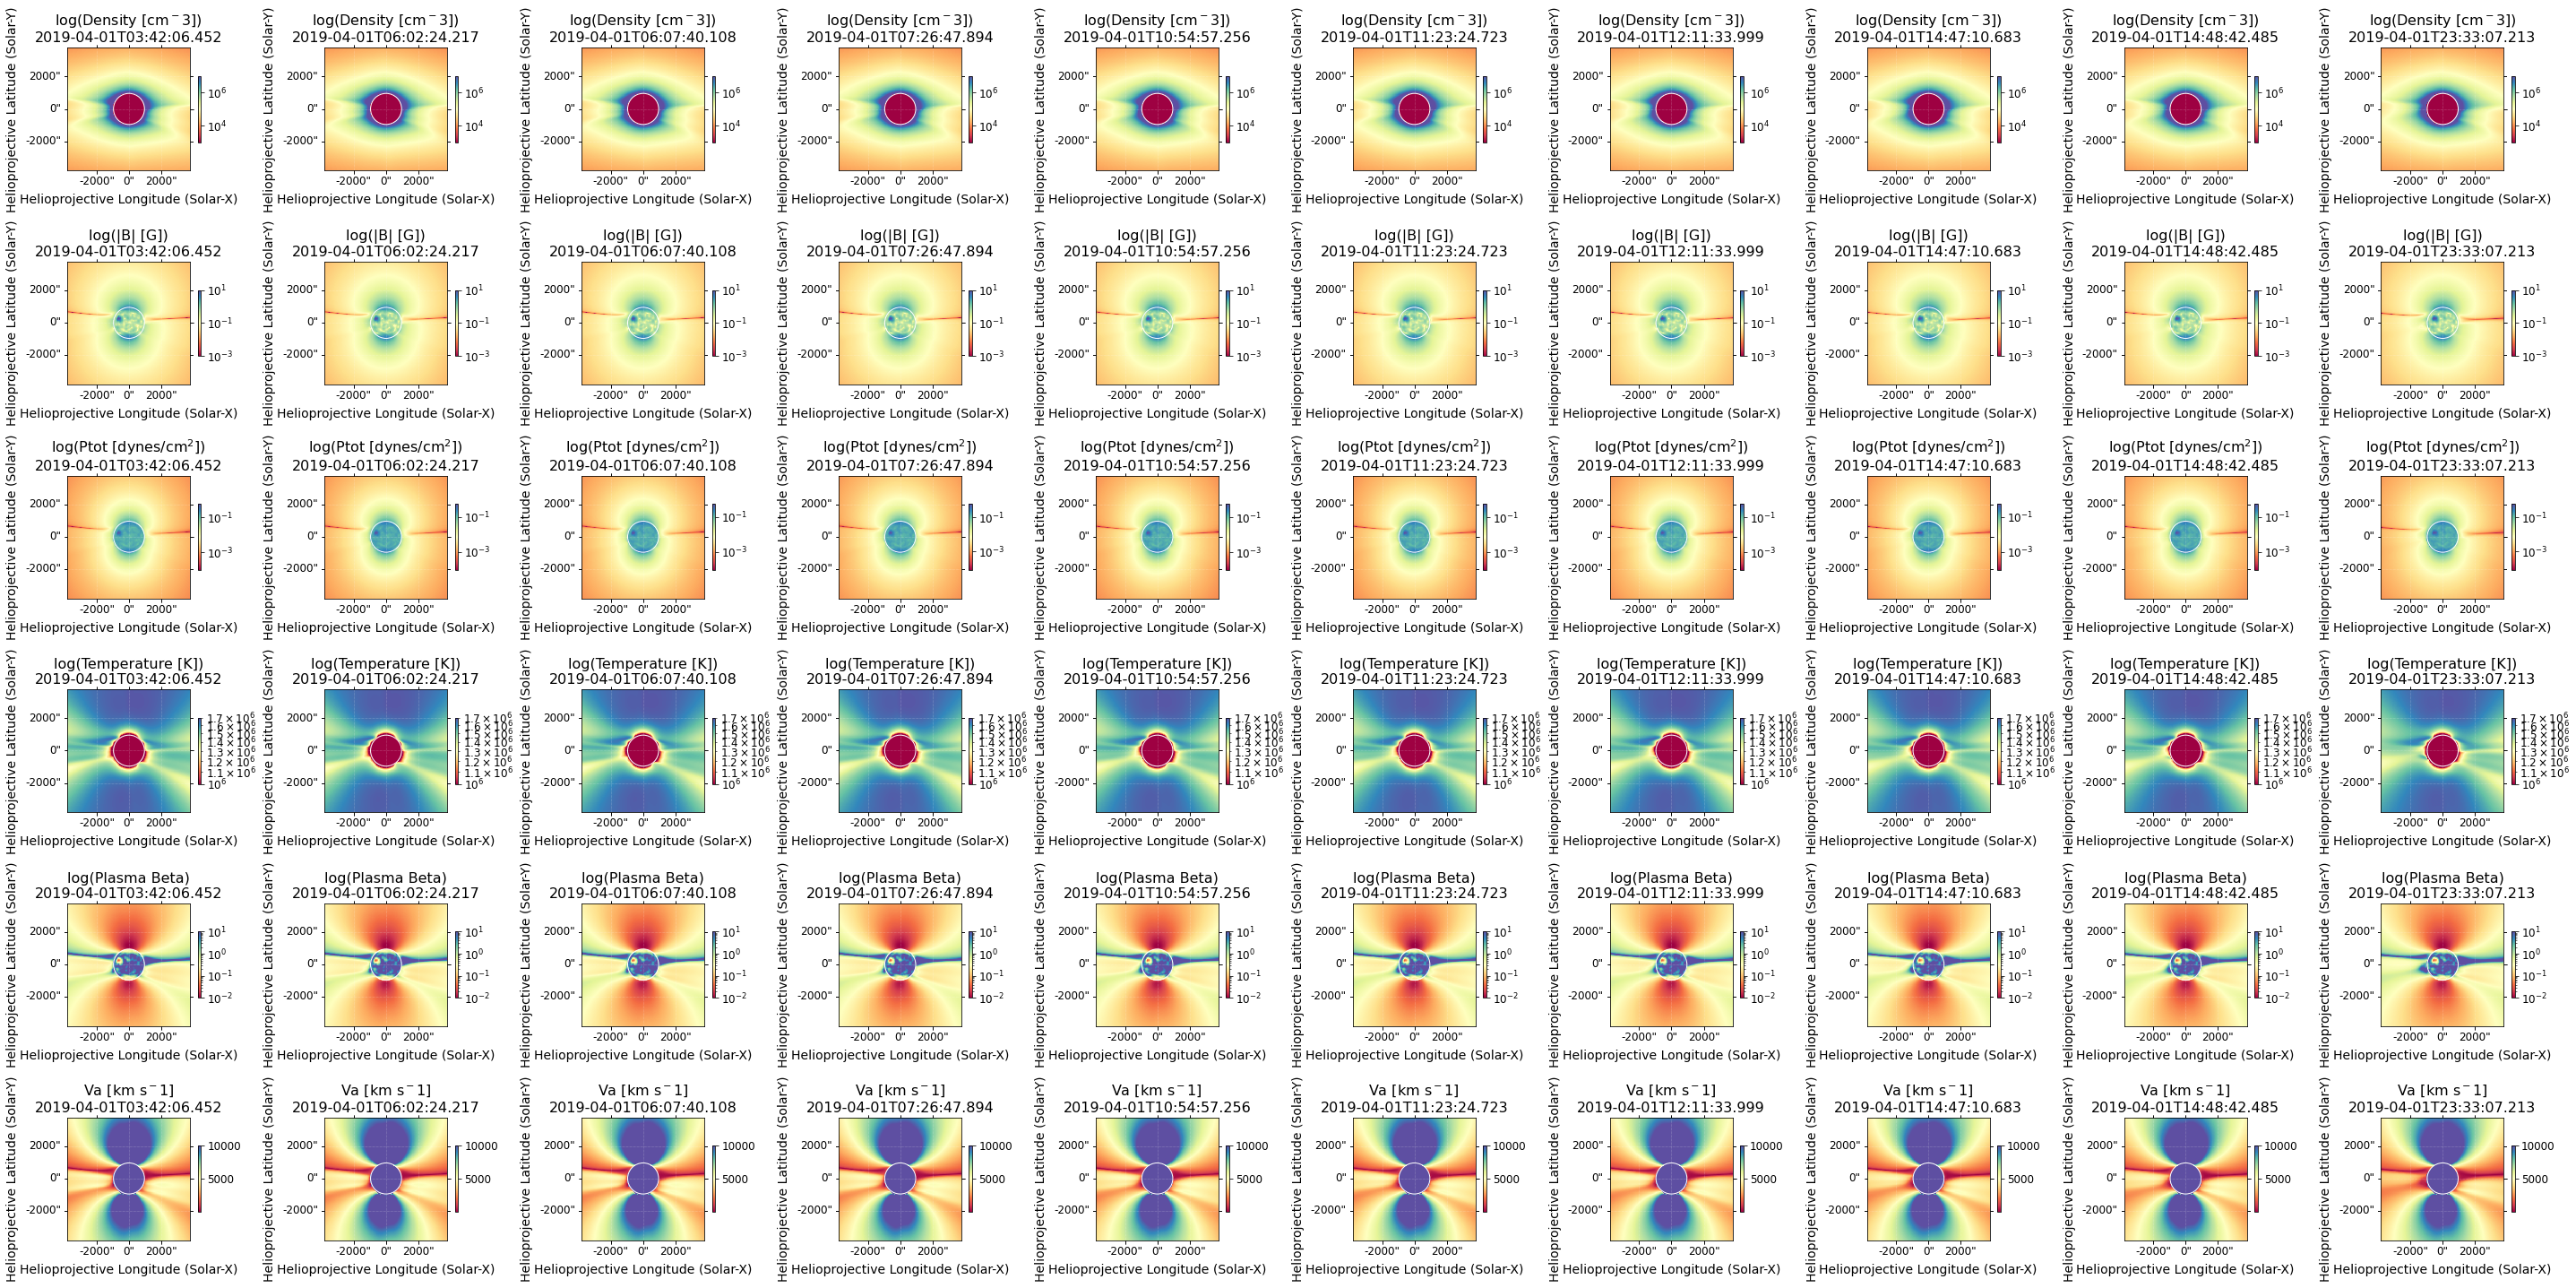

In [14]:
fig = plt.figure(figsize=[40,20])

for i, filename in enumerate(concatenated_list):
    forwardmap = sunpy.map.Map(filename)
    ax = fig.add_subplot(6, 10, i+1, projection=forwardmap)
    
    if 'dens' in filename:
        im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e3, vmax=1e7), title=f"log(Density [cm$^{-3}$])\n{forwardmap.meta['date-obs']}")
    
    elif 'bmag' in filename:
        im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e-3, vmax=1e1), title=f"log(|B| [G])\n{forwardmap.meta['date-obs']}")
    
    elif 'ptot' in filename:
        im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title=f"log(Ptot [dynes/cm$^2$])\n{forwardmap.meta['date-obs']}")
    
    elif 'temp' in filename:
        im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e6, vmax=1.7e6), title=f"log(Temperature [K])\n{forwardmap.meta['date-obs']}")
    
    elif 'beta' in filename:
        im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e-2, vmax=1e1), title=f"log(Plasma Beta)\n{forwardmap.meta['date-obs']}")
    
    elif 'valfven' in filename:
        im = forwardmap.plot(axes=ax, cmap='Spectral', vmin=0.5e2, vmax=1e4, title=f"Va [km s$^{-1}$]\n{forwardmap.meta['date-obs']}")

    forwardmap.draw_limb()
    plt.colorbar(im, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()

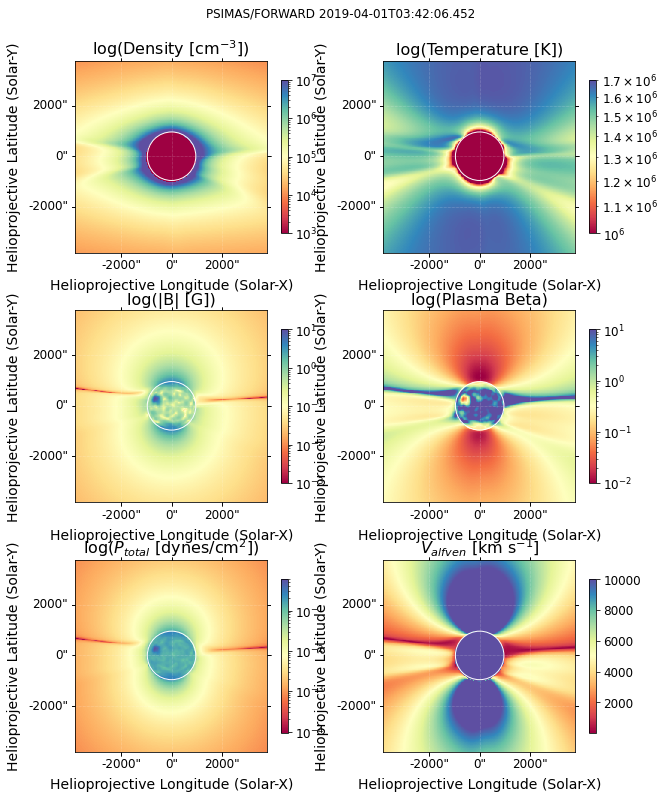

In [15]:
map_index = 0
fig = plt.figure(figsize=(10,25))

forwardmap = sunpy.map.Map(dens[map_index])
ax = fig.add_subplot(621, projection=forwardmap)
im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title='log(Density [cm$^{-3}$])', vmin=1e3, vmax=1e7)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

forwardmap = sunpy.map.Map(temp[map_index])
ax = fig.add_subplot(622, projection=forwardmap)
im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title='log(Temperature [K])', vmin=1e6, vmax=1.7e6)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

forwardmap = sunpy.map.Map(bmag[map_index])
ax = fig.add_subplot(623, projection=forwardmap)
im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title='log(|B| [G])', vmin=1e-3, vmax=1e1)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

forwardmap = sunpy.map.Map(beta[map_index])
ax = fig.add_subplot(624, projection=forwardmap)
im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title='log(Plasma Beta)', vmin=1e-2, vmax=1e1)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

forwardmap = sunpy.map.Map(ptot[map_index])
ax = fig.add_subplot(625, projection=forwardmap)
im = forwardmap.plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title='log($P_{total}$ [dynes/cm$^2$])')
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

forwardmap = sunpy.map.Map(valfven[map_index])
ax = fig.add_subplot(626, projection=forwardmap)
im = forwardmap.plot(axes=ax, cmap='Spectral', title='$V_{alfven}$ [km s$^{-1}$]', vmin=0.5e2, vmax=1e4)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)
fig.suptitle(f"{forwardmap.meta['obsrvtry']} {forwardmap.meta['date-obs']}", y=0.93)
#fig.savefig(f"{basedir}/plots/mas/{burst_num}/PSIMAS_FORWARD_plasma_diagnostics_{forwardmap.meta['date-obs']}.pdf", bbox_inches='tight')
#fig.savefig(f"{basedir}/plots/mas/{burst_num}/PSIMAS_FORWARD_plasma_diagnostics_{forwardmap.meta['date-obs']}.png", bbox_inches='tight')
plt.show()

### Base-difference images

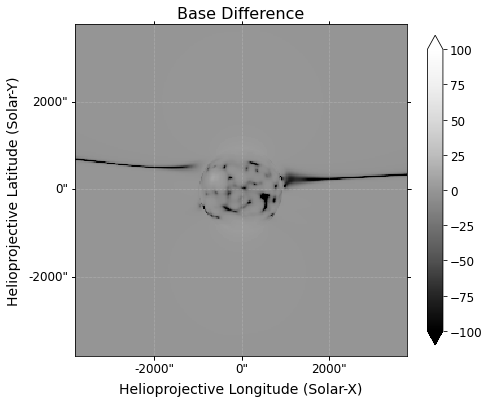

In [16]:
m_seq = sunpy.map.Map([
    sorted(glob.glob(f'{basedir}/mas/new_maps/*.fits'))
], sequence=True)

m_seq_base = sunpy.map.Map([m - m_seq[0].quantity for m in m_seq[1:]], sequence=True)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m_seq_base.maps[0])
m_seq_base.plot(axes=ax, title='Base Difference', norm=colors.Normalize(vmin=-100, vmax=100), cmap='Greys_r')
plt.colorbar(ax=ax, extend='both', shrink=0.7)
plt.tight_layout()
plt.show()

### Running-difference images

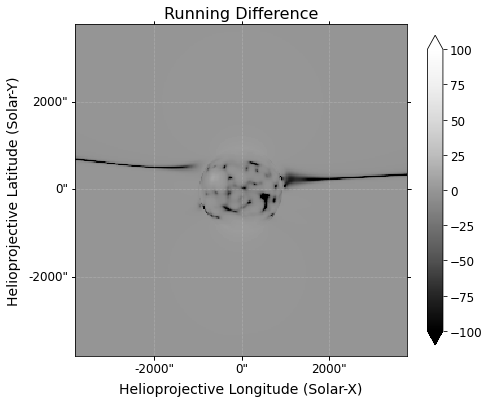

In [17]:
m_seq = sunpy.map.Map([
    sorted(glob.glob(f'{basedir}/mas/new_maps/*.fits'))
], sequence=True)

m_seq_running = sunpy.map.Map(
    [m - prev_m.quantity for m, prev_m in zip(m_seq[1:], m_seq[:-1])],
    sequence=True)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m_seq_running.maps[0])
m_seq_running.plot(axes=ax, title='Running Difference', norm=colors.Normalize(vmin=-100, vmax=100), cmap='Greys_r')
plt.colorbar(ax=ax, extend='both', shrink=0.7)
plt.tight_layout()
plt.show()

In [19]:
forward_datetime = []

for data in dens:
    date = data.split('/')[-1].split('_')[4:7][0].split('T')[0]
    hours = data.split('/')[-1].split('_')[4:7][0].split('T')[1]
    minutes = data.split('/')[-1].split('_')[4:7][1]
    seconds = data.split('/')[-1].split('_')[4:7][-1]
    forward_datetime.append(f'{date} {hours}:{minutes}:{seconds}')

In [20]:
# Reproject the LOFAR maps to overplot on the FORWARD maps
freqs = []
lofarplotmaps = []
lofar_obs_datetime = []

for img in filtered_lof_imgs_sort:
    lofar_imagemap = get_lofar_map(img, bottom_left=(-FOV,-FOV), top_right=(FOV,FOV))
    
    # store the freq and time of each LOFAR map
    freqs.append(lofar_imagemap.wavelength.value)
    lofar_obs_datetime.append(lofar_imagemap.date.value.replace('T', ' '))
    
    with sunpy.coordinates.frames.Helioprojective.assume_spherical_screen(lofar_imagemap.observer_coordinate):
        forwardmap = sunpy.map.Map(dens[0])
        lofarplotmaps.append(lofar_imagemap.reproject_to(forwardmap.wcs))

In [24]:
linwid = 2
cmap = 'Spectral'
lofar_contour = True
contour_color = 'gray'
centroid_color = 'black'
centroid_marksize = 12
contr_lvl = 70
legd_size = 10
''' 
generate a list of random colors that are clearly different 
and ensure that the generated colors are not too close in color 
by comparing the Euclidean distance between the colors in the RGB color space 
''' 
# num of colors to generate
n_colors = 100
# min distance between colors
min_distance = 50
# generate a list of random colors
cls = []
while len(cls) < n_colors:
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    randcolor = (r, g, b)
    # check if the generated color is too close to any of the previously generated colors
    too_close = False
    for c in cls:
        distance = math.sqrt((r - c[0])**2 + (g - c[1])**2 + (b - c[2])**2)
        if distance < min_distance:
            too_close = True
            break
    # if the generated color is not too close, add it to the list
    if not too_close:
        cls.append(randcolor)

# convert the RGB tuples to the range 0 - 1 to be compatible
contour_colors = [(r/255, g/255, b/255) for r, g, b in cls]
# Convert the RGBA tuples to Matplotlib color codes
contour_colors = [mpl.colors.to_hex(color) for color in contour_colors]

In [25]:
# gradiant colors ...
gradiant_colors = get_colors(len(lofarplotmaps))

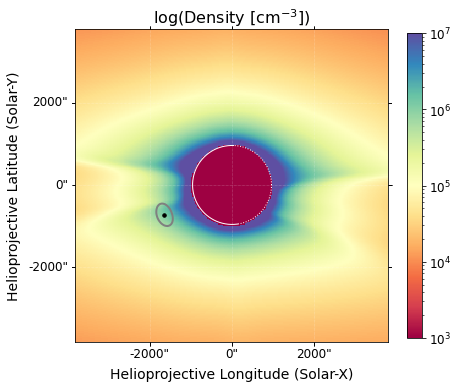

In [26]:
fig = plt.figure(figsize=[7,7])
mean_centroids = []

# DENSITY plot
forwardmap = sunpy.map.Map(dens[1])
lofmap = lofarplotmaps[1]
ax = fig.add_subplot(111, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e3, vmax=1e7), title='log(Density [cm$^{-3}$])')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

In [27]:
# index num of the list of FORWARD maps at different Carrington lon
map_index = 0
lof_index = 0
lofmap = lofarplotmaps[lof_index]

mean_centroids = []

fig = plt.figure(figsize=(16,22))

# DENSITY plot
forwardmap = sunpy.map.Map(dens[map_index])
lofmap = lofarplotmaps[lof_index]
ax = fig.add_subplot(321, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e3, vmax=1e7), title='log(Density [cm$^{-3}$])')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

chandles = []
h,_ = c.legend_elements()
chandles.append(h)

# TEMPERATURE plot
forwardmap = sunpy.map.Map(temp[map_index])
ax = fig.add_subplot(322, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e6, vmax=1.7e6), title='log(Temperature [K])')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

# BMAG plot
forwardmap = sunpy.map.Map(bmag[map_index])
ax = fig.add_subplot(323, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e-3, vmax=1e1), title='log(|B| [G])')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

# PLASMA BETA plot
forwardmap = sunpy.map.Map(beta[map_index])
ax = fig.add_subplot(324, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e-2, vmax=1e1), title='log(Plasma Beta)')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

# TOTAL PRESSURE plot
forwardmap = sunpy.map.Map(ptot[map_index])
ax = fig.add_subplot(325, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, norm=colors.LogNorm(), title='log($P_{total}$ [dynes/cm$^2$])')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

# V_Alfven plot
forwardmap = sunpy.map.Map(valfven[map_index])
ax = fig.add_subplot(326, projection=lofmap)
im = forwardmap.plot(axes=ax, cmap=cmap, vmin=0.5e2, vmax=1e4, title='$V_{alfven}$ [km s$^{-1}$]')
c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
mean_centroids.append(centroid)
ax.scatter(centroid[0], centroid[1], s=centroid_marksize, color=centroid_color)
forwardmap.draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

# create a single legend for all subplots
fig.legend([h[0] for h in chandles], [f'{freqs[map_index]:.2f} MHz, {lofar_obs_datetime[map_index]}'], prop={'size':13}, loc='lower center', bbox_to_anchor=(0.5,0.07))

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.01)
#fig.suptitle(f"{forwardmap.meta['obsrvtry']} {forwardmap.meta['date-obs']}", y=0.91)
fig.savefig(f"{basedir}/plots/mas/{burst_num}/LOFAR_FORWARD_plasma_diag_forwtime_{forwardmap.meta['date-obs']}.pdf", bbox_inches='tight')
fig.savefig(f"{basedir}/plots/mas/{burst_num}/LOFAR_FORWARD_plasma_diag_forwtime_{forwardmap.meta['date-obs']}.png", bbox_inches='tight')
plt.show()

In [29]:
# make a list of FORWARD plasma quantities at the `map_index` Carrington lon in the list
diagmaps = [
    sunpy.map.Map(dens[map_index]),
    sunpy.map.Map(temp[map_index]),
    sunpy.map.Map(bmag[map_index]),
    sunpy.map.Map(beta[map_index]),
    sunpy.map.Map(ptot[map_index]),
    sunpy.map.Map(valfven[map_index])
]

In [31]:
# sanity check ... 
for i, diagmap in enumerate(diagmaps):
    print(f"[{i}]\t{diagmap.meta['instrume']}")

[0]	Density
[1]	Temperature
[2]	Bmag
[3]	Plasma Beta
[4]	Total Pressure
[5]	Density


In [32]:
# sample random points within the radio contour area on the forward map
num_rand_points = 104
meancoords = {}
randcoords = {}
f_freq_plasma = {}
chandles = []
df_randpoints = []
forward_param_lst = []

# make an empty dataframe to store the plasma parameters
df_plasma = pd.DataFrame(columns=[f'{freqs[map_index]} MHz'], index=[diagmaps[map_index].meta['instrume']])
df_forward_param = pd.DataFrame(columns=[f'{freqs[map_index]} MHz'], index=range(num_rand_points))

fig = plt.figure(figsize=(7,7))

# index of the FORWAARD palsma quantity at a fixed Carrington lon
n = 0
lofmap = lofarplotmaps[map_index]

ax = fig.add_subplot(projection=lofmap)

# plot the FORWARD map
im = diagmaps[n].plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e3, vmax=1e7), title='log(Density [cm$^{-3}$])')
diagmaps[n].draw_limb()
plt.colorbar(im, ax=ax, shrink=0.8)

c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
h,_ = c.legend_elements()
chandles.append(h)

# record the contour points in a list
points = c.allsegs[0][0]
centroid = points.mean(axis=0)
centroid_X = centroid[0]
centroid_Y = centroid[1]

# plot the centorid loc
ax.scatter(centroid_X, centroid_Y, s=centroid_marksize, color=centroid_color)

# convert the centroids loc to the LOFAR image frame of reference
meancoords.update({f'{freqs[map_index]:.2f} MHz': lofmap.pixel_to_world(centroid_X*u.pix, centroid_Y*u.pix)})

# convert the centroids loc to the FORWARD map frame of reference
meanvalpixinds = [diagmaps[n].world_to_pixel(meancoords[coord]) for coord in meancoords]

# store the plasma param at the mean centoids of each freq
meanparamvals = [diagmaps[n].data[round(valpixind[0].value), round(valpixind[1].value)] for valpixind in meanvalpixinds]
meanvalstr = [f'{param:.3e}' for param in meanparamvals]

# add a new empty col for each freq and append the plasma param to it
#f_freq_plasma.update({f'{freqs[map_index]:.2f} MHz': meanparamvals[0]})
f_freq_plasma.update({diagmaps[map_index].instrument: meanparamvals[0]})

# convert from pix to arcsec
centr_arcsec = lofarplotmaps[map_index].pixel_to_world(centroid_X*u.pix, centroid_Y*u.pix)
print(f'{[n]}: {diagmaps[n].instrument} at {freqs[map_index]:.2f} MHz centroid ({centr_arcsec.Tx.value:.2f}, {centr_arcsec.Ty.value:.2f}) arcsec:\t{float(meanparamvals[0]):.3e} cm-3')

# extract the x-point and y-points of the ellipse
increment_dist = 3
xell = points[:,0]
yell = points[:,1]

xnew, ynew = generate_random_points_within_ellipse(contour_colors, num_rand_points, xell, yell, increment_dist, centroid_X, centroid_Y, points)

# store the former values at the specified plasma param
df_plasma.loc[diagmaps[map_index].instrument] = f_freq_plasma

# store the plasma param at the each rand point within every contour lines 
df_randpoints.append(pd.DataFrame([{'FREQ': f'{freqs[map_index]:.2f} MHz',
                                    'Coordinates': pd.DataFrame({'Xcnew': xnew, 'Ycnew': ynew})}]))
randvalstr = []
for i in range(len(df_randpoints[map_index]['Coordinates'][0])):
    randparamval = diagmaps[n].data[df_randpoints[map_index]['Coordinates'][0].iloc[i]['Xcnew'],
                                    df_randpoints[map_index]['Coordinates'][0].iloc[i]['Ycnew']]
    # palsma quantity value at each rand centroid
    randvalstr.append(randparamval)

# Pad the list with NaN values to match the length of the DataFrame
randvalstr_padded = randvalstr + [np.nan]*(num_rand_points - len(randvalstr))

# Assign the padded list to a new column in the DataFrame
df_forward_param[f'{freqs[map_index]:.2f} MHz'] = randvalstr_padded

# rename the dataframe based on the plasma param stored in it
globals()[f'df_forward_{diagmaps[n].instrument}'] = df_forward_param

# store the dataframe in a list
forward_param_lst.append(eval(f'df_forward_{diagmaps[map_index].instrument}'))

ax.legend([h0[0] for h0 in chandles], [f'{f:.2f} MHz' for f in freqs], ncol=3, prop={'size':legd_size}, loc='upper center')
plt.show()

[0]: Density at 72.26 MHz centroid (-1526.18, -749.08) arcsec:	4.839e+05 cm-3


In [36]:
def stand_err(var=None):
    '''
    This functions calculates the standard error of a variable.
    Input:
    var --> DataFrame of n columns for FREQs.
    Output:
    err --> A list of standard errors for each column of var.
    '''
    tmp_n = var.dropna().values
    err = np.std(tmp_n)/np.sqrt(len(tmp_n))
    return err

In [37]:
# calc the standard err for each plasma param
err_n = stand_err(var=df_forward_Density)

# add the err val to the dict
f_freq_plasma.update({'stand_err': err_n})

In [38]:
# show as a dataframe
pd.DataFrame(f_freq_plasma, index=[f'{freqs[map_index]:.2f} MHz'])

Density     stand_err
72.26 MHz  483944.087594  22521.080868

### Check map-by-map

NameError: name 'instrument_name' is not defined

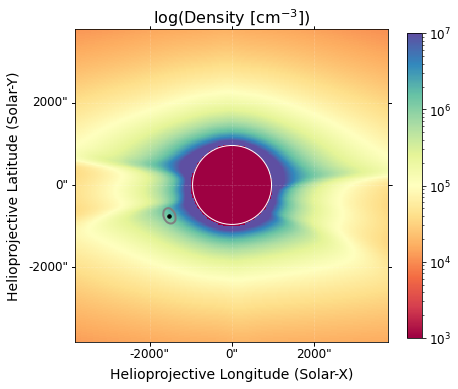

In [40]:
# sample random points within the radio contour area on the forward map
num_rand_points = 104
meancoords = {}
randcoords = {}
f_freq_plasma = {}
chandles = []
df_randpoints = []
forward_param_lst = []
list_of_dfs_plasma_vals = []

# make an empty dataframes to store the plasma parameters
df_plasma = pd.DataFrame()
df_forward_param = pd.DataFrame()


# i = 0
# lofmap = lofarplotmaps[i]

for i, lofmap in enumerate(lofarplotmaps):

    # make a list of FORWARD plasma quantities at the `map_index` Carrington lon in the list
    diagmaps = [
        sunpy.map.Map(dens[i]),
        sunpy.map.Map(temp[i]),
        sunpy.map.Map(bmag[i]),
        sunpy.map.Map(beta[i]),
        sunpy.map.Map(ptot[i]),
        sunpy.map.Map(valfven[i])
    ]

    # index of the FORWAARD palsma quantity
    # e.g. 0 for Density map
    n = 0
    df_plasma[f'{freqs[i]} MHz'] = np.nan


    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection=lofmap)

    # plot the FORWARD map
    if n == 0:
        im = diagmaps[n].plot(axes=ax, cmap=cmap, norm=colors.LogNorm(vmin=1e3, vmax=1e7), title='log(Density [cm$^{-3}$])')
    elif n == 1:
        im = diagmaps[n].plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e6, vmax=1.7e6), title='log(Temperature [K])')
    elif n == 2:
        im = diagmaps[n].plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e-3, vmax=1e1), title='log(|B| [G])')
    elif n == 3:
        im = diagmaps[n].plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(vmin=1e-2, vmax=1e1), title='log(Plasma Beta)')
    elif n == 4:
        im = diagmaps[n].plot(axes=ax, cmap='Spectral', norm=colors.LogNorm(), title='log($P_{total}$ [dynes/cm$^2$])')
    elif n == 5:
        im = diagmaps[n].plot(axes=ax, cmap='Spectral', vmin=0.5e2, vmax=1e4, title='$V_{alfven}$ [km s$^{-1}$]')
    
    diagmaps[n].draw_limb()
    plt.colorbar(im, ax=ax, shrink=0.8)

    c = lofmap.draw_contours(axes=ax, levels=[contr_lvl]*u.percent, autoalign=True, linewidths=linwid, colors=contour_color)
    h,_ = c.legend_elements()
    chandles.append(h)

    # record the contour points in a list
    points = c.allsegs[0][0]
    centroid = points.mean(axis=0)
    centroid_X = centroid[0]
    centroid_Y = centroid[1]

    # plot the centorid loc
    ax.scatter(centroid_X, centroid_Y, s=centroid_marksize, color=centroid_color)
    
    # correct the instrument name for the valfven speed map
    if n == 5:
        diagmaps[n].meta['instrume'] = 'Alfven_Speed'
    
    # remove the space to avoid errors
    if ' ' in diagmaps[n].instrument:
        instrument_name = diagmaps[n].instrument.replace(' ', '_')
    
    # store the plasma param at the mean centoids of each freq
    meanparamval = diagmaps[n].data[round(centroid_X), round(centroid_Y)]
    meanvalstr = f'{meanparamval:.3e}'


    # add a new empty col for each freq and append the plasma param to it
    f_freq_plasma.update({instrument_name: meanparamval})

    # convert from pix to arcsec
    centr_arcsec = lofmap.pixel_to_world(centroid_X*u.pix, centroid_Y*u.pix)
    print(f'{[i]}: {instrument_name} at {freqs[i]:.2f} MHz centroid ({centr_arcsec.Tx.value:.2f}, {centr_arcsec.Ty.value:.2f}) arcsec:\t{meanvalstr} cm-3')

    # extract the x-point and y-points of the ellipse
    increment_dist = 3
    xell = points[:,0]
    yell = points[:,1]

    xnew, ynew = generate_random_points_within_ellipse(contour_colors, num_rand_points, xell, yell, increment_dist, centroid_X, centroid_Y, points)

    # store the former values at the specified plasma param
    df_plasma[f'{freqs[i]} MHz'].loc[instrument_name] = f_freq_plasma

    # store the plasma param at the each rand point within every contour lines 
    df_randpoints.append(pd.DataFrame([{'FREQ': f'{freqs[i]:.2f} MHz',
                                        'Coordinates': pd.DataFrame(
                                            {
                                            'Xcnew': xnew,
                                            'Ycnew': ynew
                                            }
                                        )}
                                      ]))
    randvalstr = []
    for j in range(len(df_randpoints[0]['Coordinates'][0])):
        randparamval = diagmaps[n].data[df_randpoints[0]['Coordinates'][0]['Xcnew'][j],
                                        df_randpoints[0]['Coordinates'][0]['Ycnew'][j]
                                       ]
        # palsma quantity value at each rand centroid
        randvalstr.append(randparamval)

    # Pad the list with NaN values to match the length of the DataFrame
    randvalstr_padded = randvalstr + [np.nan]*(num_rand_points - len(randvalstr))

    # Assign the padded list to a new column in the DataFrame
    df_forward_param[f'{freqs[i]:.2f} MHz'] = randvalstr_padded

    # rename the dataframe based on the plasma param stored in it
    globals()[f'df_forward_{instrument_name}'] = df_forward_param

    # store the dataframe in a list
    forward_param_lst.append(eval(f'df_forward_{instrument_name}'))

    plt.show()

    # calc the standard err for each plasma param
    err_n = stand_err(var=eval(f'df_forward_{instrument_name}'))

    # add the err val to the dict
    f_freq_plasma.update({'stand_err': err_n})

    # save it in a list to concat them later
    df_plasma_val_and_err = pd.DataFrame(f_freq_plasma, index=[f'{freqs[i]:.2f} MHz'])
    list_of_dfs_plasma_vals.append(df_plasma_val_and_err)

    # show as a dataframe
    print(
        pd.DataFrame(f_freq_plasma, index=[f'{freqs[i]:.2f} MHz'])
    )
    print(f"\n{instrument_name}:\t{f_freq_plasma[instrument_name]:.2e} +/- {f_freq_plasma['stand_err']:.2e} cm-3\n")


# Merge the DataFrames vertically; along rows
df = pd.concat(list_of_dfs_plasma_vals)
df.to_csv(f'{basedir}/plots/mas/{burst_num}/{instrument_name}.csv')
df

In [41]:
glob.glob(f'{basedir}/plots/mas/{burst_num}/*.csv')

['/HDD/mnedal/plots/mas/burst_06/Plasma_Beta.csv',
 '/HDD/mnedal/plots/mas/burst_06/Density.csv',
 '/HDD/mnedal/plots/mas/burst_06/Temperature.csv',
 '/HDD/mnedal/plots/mas/burst_06/Alfven_Speed.csv',
 '/HDD/mnedal/plots/mas/burst_06/Total_Pressure.csv',
 '/HDD/mnedal/plots/mas/burst_06/Bmag.csv']

In [42]:
# load the saved dataframes
df_dens = pd.read_csv(f'{basedir}/plots/mas/{burst_num}/Density.csv')
df_temp = pd.read_csv(f'{basedir}/plots/mas/{burst_num}/Temperature.csv')
df_bmag = pd.read_csv(f'{basedir}/plots/mas/{burst_num}/Bmag.csv')
df_ptot = pd.read_csv(f'{basedir}/plots/mas/{burst_num}/Total_Pressure.csv')
df_beta = pd.read_csv(f'{basedir}/plots/mas/{burst_num}/Plasma_Beta.csv')
df_valfven = pd.read_csv(f'{basedir}/plots/mas/{burst_num}/Alfven_Speed.csv')

df_dens.set_index('Unnamed: 0', inplace=True)
df_bmag.set_index('Unnamed: 0', inplace=True)
df_temp.set_index('Unnamed: 0', inplace=True)
df_ptot.set_index('Unnamed: 0', inplace=True)
df_beta.set_index('Unnamed: 0', inplace=True)
df_valfven.set_index('Unnamed: 0', inplace=True)

In [43]:
def Ne_f(f):
    '''
    Convert frequency (Hz) to the equivalent plasma density (cm-3).
    '''
    return (f/8.98e3)**2

def newkirk_h(r):
    ''' 
    Newkirk electron-density model; harmonic emission.
    e.g. `fold` is a multiplicative factor to change the density scaling.
    '''
    fold = 2.5
    return fold*4.2e4*10**(4.32/r)


# assuming fundamental freq
fp1 = np.array(freqs)*10**6 # f from MHz to Hz
np1 = Ne_f(fp1)

# assuming 2nd harmonic freq
fp2 = (np.array(freqs)/2)*10**6 # divided by 2 to get the fundamental component
np2 = Ne_f(fp2)

In [44]:
# radial distaces of radio sources, taken from the plot3Dsource notebook
rad_dist = [1.80653488, 2.06625674, 2.24073875, 2.19835155, 2.73117155, 2.74240371, 2.67787544, 3.24652271, 3.44687932, 3.48885054]

# Newkirk densities
n_newkirk = [newkirk_h(r) for r in rad_dist]

In [45]:
[f'{n:.2e}' for n in n_newkirk]

['2.59e+07',
 '1.29e+07',
 '8.89e+06',
 '9.69e+06',
 '4.01e+06',
 '3.95e+06',
 '4.31e+06',
 '2.25e+06',
 '1.88e+06',
 '1.82e+06']

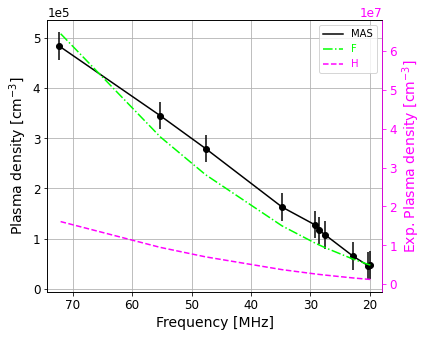

In [46]:
# remove the str part and convert to float number
freq_axis = [float(f.split(' ')[0]) for f in df_dens.index]

fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
ax.plot(freq_axis, df_dens['Density'], color='black', label='MAS')
ax.errorbar(freq_axis, df_dens['Density'], yerr=df_dens['stand_err'], fmt='o', color='black')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Plasma density [cm$^{-3}$]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid()
# Flip the x-axis
ax.set_xlim(freq_axis[::-1][-1]+2, freq_axis[::-1][0]-2)

ax2 = ax.twinx()
ax2.plot(freqs[::-1], np1[::-1], '-.', color='lime', label='F')
ax2.plot(freqs[::-1], np2[::-1], '--', color='fuchsia', label='H')
ax2.spines['right'].set_color('fuchsia')
ax2.yaxis.label.set_color('fuchsia')
ax2.tick_params(axis='y', colors='fuchsia')
ax2.set_ylabel('Exp. Plasma density [cm$^{-3}$]')

# Add a single legend for both the axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, labelcolor=['black', 'lime', 'fuchsia'], loc='upper right', fontsize=10)
plt.show()

In [47]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
ax.plot(freq_axis, df_dens['Density'], color='black', label='MAS')
ax.errorbar(freq_axis, df_dens['Density'], yerr=df_dens['stand_err'], fmt='o', color='black')

ax.plot(freqs[::-1], np1[::-1], '-.', color='lime', label='Fundamental')
ax.plot(freqs[::-1], np2[::-1], '-.', color='fuchsia', label='Harmonic')
ax.plot(freqs, n_newkirk, '+-', color='dodgerblue', label='2.5×Newkirk')

ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Plasma density [cm$^{-3}$]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid()
ax.set_xlim(freq_axis[::-1][-1]+2, freq_axis[::-1][0]-2) # Flip the x-axis

ax.legend(loc='lower left', fontsize=10)
ax.set_yscale('log')
plt.show()

In [48]:
df_ptot

Total_Pressure   stand_err
Unnamed: 0                            
72.26 MHz     12135.276902  161.875566
55.27 MHz     12177.799936  161.269362
47.65 MHz     12344.906629  161.051326
34.76 MHz     10399.991865  160.777158
29.29 MHz      8485.564138  160.328563
28.51 MHz      8108.474071  159.998023
27.53 MHz      7112.953875  159.723018
22.85 MHz      7954.352111  159.423998
20.31 MHz      6927.649787  159.187694
19.92 MHz      6819.149052  158.930530

### PLOT THE PLASMA VALUES AT THE CENTROIDS VS. FREQ

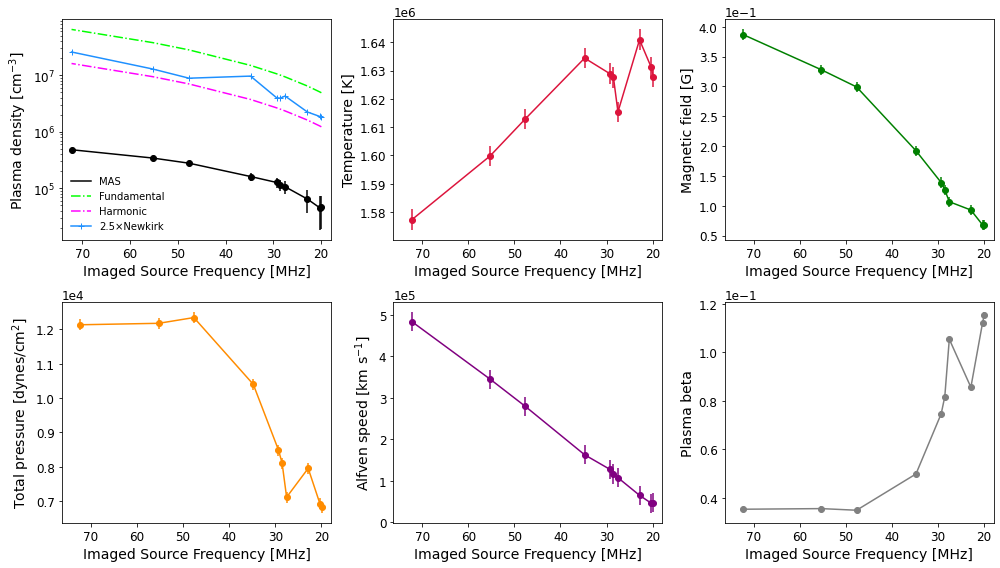

In [49]:
fig = plt.figure(figsize=[14,8])

# DENSITY plot
ax = fig.add_subplot(231)
'''
ax.plot(freq_axis, df_dens['Density'], color='black', label='MAS')
ax.errorbar(freq_axis, df_dens['Density'], yerr=df_dens['stand_err'], fmt='o', color='black')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Plasma density [cm$^{-3}$]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid()
# Flip the x-axis
ax.set_xlim(freq_axis[::-1][-1]+2, freq_axis[::-1][0]-2)

ax2 = ax.twinx()
ax2.plot(freqs[::-1], np1[::-1], '-.', color='lime', label='F')
ax2.plot(freqs[::-1], np2[::-1], '--', color='fuchsia', label='H')
ax2.spines['right'].set_color('fuchsia')
ax2.yaxis.label.set_color('fuchsia')
ax2.tick_params(axis='y', colors='fuchsia')
ax2.set_ylabel('Exp. Plasma density [cm$^{-3}$]')

# Add a single legend for both the axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, labelcolor=['black', 'lime', 'fuchsia'], loc='upper right', fontsize=10)
'''
ax.plot(freq_axis, df_dens['Density'], color='black', label='MAS')
ax.errorbar(freq_axis, df_dens['Density'], yerr=df_dens['stand_err'], fmt='o', color='black')
ax.plot(freqs[::-1], np1[::-1], '-.', color='lime', label='Fundamental')
ax.plot(freqs[::-1], np2[::-1], '-.', color='fuchsia', label='Harmonic')
ax.plot(freqs, n_newkirk, '+-', color='dodgerblue', label='2.5×Newkirk')
ax.set_xlabel('Imaged Source Frequency [MHz]')
ax.set_ylabel('Plasma density [cm$^{-3}$]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#ax.grid()
ax.set_xlim(freq_axis[::-1][-1]+2, freq_axis[::-1][0]-2) # Flip the x-axis
ax.legend(loc='lower left', frameon=False, fontsize=10)
ax.set_yscale('log')

# ========================================================================================

# TEMPERATURE
ax = fig.add_subplot(232)
ax.plot(freq_axis, df_temp['Temperature'], color='crimson')
ax.errorbar(freq_axis, df_temp['Temperature'], yerr=df_temp['stand_err'], fmt='o', color='crimson')
ax.set_xlabel('Imaged Source Frequency [MHz]')
ax.set_ylabel('Temperature [K]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim(freqs[::-1][-1]+4, freqs[::-1][0]-2)
#ax.grid()

# ========================================================================================

# BMAG
ax = fig.add_subplot(233)
ax.plot(freq_axis, df_bmag['Bmag'], color='green')
ax.errorbar(freq_axis, df_bmag['Bmag'], yerr=df_bmag['stand_err'], fmt='o', color='green')
ax.set_xlabel('Imaged Source Frequency [MHz]')
ax.set_ylabel('Magnetic field [G]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim(freqs[::-1][-1]+4, freqs[::-1][0]-2)
#ax.grid()

# ========================================================================================

# PRESURE
ax = fig.add_subplot(234)
ax.plot(freq_axis, df_ptot['Total_Pressure'], color='darkorange')
ax.errorbar(freq_axis, df_ptot['Total_Pressure'], yerr=df_ptot['stand_err'], fmt='o', color='darkorange')
ax.set_xlabel('Imaged Source Frequency [MHz]')
ax.set_ylabel('Total pressure [dynes/cm$^2$]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim(freqs[::-1][-1]+4, freqs[::-1][0]-2)
#ax.grid()

# ========================================================================================

# VA
ax = fig.add_subplot(235)
ax.plot(freq_axis, df_valfven['Alfven_Speed'], color='purple')
ax.errorbar(freq_axis, df_valfven['Alfven_Speed'], yerr=df_valfven['stand_err'], fmt='o', color='purple')
ax.set_xlabel('Imaged Source Frequency [MHz]')
ax.set_ylabel('Alfven speed [km s$^{-1}$]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim(freqs[::-1][-1]+4, freqs[::-1][0]-2)
#ax.grid()

# PLASMA BETA
ax = fig.add_subplot(236)
ax.plot(freq_axis, df_beta['Plasma_Beta'], color='gray')
ax.errorbar(freq_axis, df_beta['Plasma_Beta'], yerr=df_beta['stand_err'], fmt='o', color='gray')
ax.set_xlabel('Imaged Source Frequency [MHz]')
ax.set_ylabel('Plasma beta')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim(freqs[::-1][-1]+4, freqs[::-1][0]-2)
#ax.grid()

# ========================================================================================

#fig.subplots_adjust(hspace=0.3, wspace=0.4)
plt.tight_layout()
fig.savefig(f'{basedir}/plots/mas/{burst_num}/scatterplots_FORWARD_plasma_diagnostics_'+psimas_date+'_'+psimasres+'.pdf', bbox_inches='tight')
fig.savefig(f'{basedir}/plots/mas/{burst_num}/scatterplots_FORWARD_plasma_diagnostics_'+psimas_date+'_'+psimasres+'.png', bbox_inches='tight')
plt.show()

In [50]:
print('Some info: \n===========')
print('* Number of obs. freqs is different for each radio burst.')
print('* Number of radnom generated points inside each radio contour might be different.')
print(f'* Number of radio bursts: \t{len(forward_param_meancentroid_bursts)}')
print(f'* Number of plasma params: \t{len(forward_param_meancentroid_bursts[0])}')
_ = [print(f'\t\t\t{[i]}\t{m.instrument}') for i, m in enumerate(diagmaps)]

Some info: 
* Number of obs. freqs is different for each radio burst.
* Number of radnom generated points inside each radio contour might be different.


NameError: name 'forward_param_meancentroid_bursts' is not defined

In [ ]:
def get_colors(n):
    '''
    Generate a list of (n) hex colors.
    '''
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    hex_colors = [mcolors.to_hex(c) for c in colors]
    hex_colors[0] = '#0000ff' # set first color to blue
    hex_colors[-1] = '#ff0000' # set last color to red
    return hex_colors

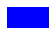

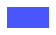

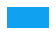

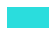

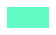

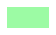

In [114]:
gradiant_colors = get_colors(10)
for c in gradiant_colors:
    cmap = ListedColormap([c])
    plt.figure(figsize=(1,1))
    plt.imshow([[0,1]], cmap=cmap, interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()
    plt.show()